## Ingest and View Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
POSTGRES_USERNAME = 'root'
POSTGRES_PASSWORD = 'koBREipm4h7CuRKix2Tn'
POSTGRES_HOSTNAME = 'database-1.c3ma8u2guxxs.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_DBNAME = 'postgres'

connection_string = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"
engine = create_engine(connection_string)

In [3]:
query = """
SELECT * FROM darwin
"""

df = pd.read_sql(query, engine)

In [4]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,None,19:31:00,19:31:30,19:31:00,19:31:00,...,4,10.0,None,None,None,None,False,False,None,None
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,None,19:37:00,19:38:00,19:37:00,19:38:00,...,A,NaN,None,None,None,None,False,False,None,None
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,None,19:30:30,19:31:00,19:31:00,19:31:00,...,2,NaN,None,None,None,None,False,False,None,None
3,202407036735756,C35756,2024-07-03,TD,BRMB,None,19:33:00,19:33:30,19:33:00,19:33:00,...,1,NaN,None,None,None,None,False,False,None,None
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,None,19:35:00,19:35:30,19:35:00,19:35:00,...,2,NaN,None,None,None,None,False,False,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43297 entries, 0 to 43296
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                43297 non-null  object 
 1   unique_id               43297 non-null  object 
 2   service_start_date      43297 non-null  object 
 3   update_origin           42840 non-null  object 
 4   train_platform          43297 non-null  object 
 5   working_time_pass       0 non-null      object 
 6   working_time_arrival    43297 non-null  object 
 7   working_time_departure  43297 non-null  object 
 8   planned_time_arrival    39705 non-null  object 
 9   planned_time_departure  39601 non-null  object 
 10  actual_arrival_time     39660 non-null  object 
 11  actual_departure_time   41885 non-null  object 
 12  platform                40177 non-null  object 
 13  train_length            11448 non-null  float64
 14  estimated_time          0 non-null    

## Clean DF 
**Drop Null Columns and Unnecessary Columns**

In [6]:
# columns to drop due to null values
columns_to_drop = [
    'working_time_pass',
    'estimated_time',
    'source',
    'actual_time',
    'actual_time_class',
    'source_instance',
    'estimated_time_minutes',
    'train_length'            
]

df_cleaned = df.drop(columns=columns_to_drop)

## Delays
**Adding Delayed Column and percentage delayed based on route_id**

In [7]:
# Create the 'delayed' column
df_cleaned['delayed'] = df_cleaned['is_delayed_arrival'] | df_cleaned['is_delayed_departure']

# Calculate the count of delays for each route_id
delay_counts = df_cleaned.groupby('route_id')['delayed'].sum().reset_index()
delay_counts.rename(columns={'delayed': 'delayed_counts'}, inplace=True)

# Calculate the total count of records for each route_id
total_counts = df_cleaned.groupby('route_id')['route_id'].count().reset_index(name='total_counts')

# Merge the delay counts and total counts
delay_summary = delay_counts.merge(total_counts, on='route_id')

# Calculate the % delayed for each route_id
delay_summary['% delayed'] = (delay_summary['delayed_counts'] / delay_summary['total_counts']) * 100

# Merge the delay summary back to the original DF
df_cleaned = df_cleaned.merge(delay_summary[['route_id', 'delayed_counts', 'total_counts', '% delayed']], on='route_id', how='left')


In [8]:
# the central idea
# df_cleaned['delayed_departure_time'] = df_cleaned['working_time_departure'] - df_cleaned['actual_departure_time']

In [9]:
# check
df_cleaned[df_cleaned['delayed']==True].head(5)


,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,delayed,delayed_counts,total_counts,% delayed
111,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,19:33:00,1,True,True,True,1,2,50.0
117,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,19:34:00,None,True,True,True,3,3,100.0
177,202407037154103,G54103,2024-07-03,Darwin,THBDGS,19:22:00,19:23:30,19:22:00,19:23:00,None,19:32:00,3,False,True,True,10,10,100.0
178,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,19:35:00,2,True,True,True,10,10,100.0
179,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,19:38:00,2,True,True,True,10,10,100.0


In [10]:
# check how is_delayed arrivals/departures compare with delayed column
df_cleaned['is_delayed_arrival'].value_counts()

is_delayed_arrival
False    40127
True      3170
Name: count, dtype: int64

In [11]:
df_cleaned['is_delayed_departure'].value_counts()

is_delayed_departure
False    39946
True      3351
Name: count, dtype: int64

In [12]:
df_cleaned['delayed'].value_counts()

delayed
False    39946
True      3351
Name: count, dtype: int64

Delayed column has same counts as is_delayed_departure. 

## Using RailReferences to Replace Train Platform with Station Name

In [13]:
# load in rail refrences
reference_df = pd.read_csv("./Copy of RailReferences - RailReferences.csv")

# only look at specified columns
reference_df = reference_df[['TiplocCode', 'StationName']]  # Tiploc is shorthand for "Timing Point Location"

# check
reference_df.head()

,TiplocCode,StationName
0,PENZNCE,Penzance Rail Station
1,STIVES,St Ives (Cornwall) Rail Station
2,CARBISB,Carbis Bay Rail Station
3,STERTH,St Erth Rail Station
4,LELANTS,Lelant Saltings Rail Station


In [14]:
# Merge df_cleaned with reference_df
df_merged = df_cleaned.merge(reference_df, left_on='train_platform', right_on='TiplocCode', how='left')

In [15]:
# check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,delayed,delayed_counts,total_counts,% delayed,TiplocCode,StationName
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,False,0,4,0.0,SCROYDN,South Croydon Rail Station
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,False,0,8,0.0,NaN,NaN
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,False,0,9,0.0,ESTHRAK,Eastham Rake Rail Station
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,False,0,9,0.0,BRMB,Bromborough Rail Station
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,False,0,9,0.0,BRMBRK,Bromborough Rake Rail Station


In [16]:
# easier view
df_merged[['train_platform', 'TiplocCode', 'StationName']].head(10)

,train_platform,TiplocCode,StationName
0,SCROYDN,SCROYDN,South Croydon Rail Station
1,LIVSTLL,NaN,NaN
2,ESTHRAK,ESTHRAK,Eastham Rake Rail Station
3,BRMB,BRMB,Bromborough Rail Station
4,BRMBRK,BRMBRK,Bromborough Rake Rail Station
5,SPITAL,SPITAL,Spital Rail Station
6,PSLT,PSLT,Port Sunlight Rail Station
7,BEBNGTN,BEBNGTN,Bebington Rail Station
8,ROCKFRY,ROCKFRY,Rock Ferry Rail Station
9,RADYR,RADYR,Radyr Rail Station


In [17]:
# checking where train_platform has no related StationName/Tiploccode
nan_rows = df_merged[df_merged[['TiplocCode', 'StationName']].isna().any(axis=1)]

nan_rows[['train_platform', 'TiplocCode', 'StationName']]

,train_platform,TiplocCode,StationName
1,LIVSTLL,NaN,NaN
16,WOLWXR,NaN,NaN
23,FRMPKRS,NaN,NaN
24,HRNS451,NaN,NaN
25,BOWERRL,NaN,NaN
...,...,...,...
43288,CANWHRF,NaN,NaN
43289,CUSTMHS,NaN,NaN
43290,WOLWXR,NaN,NaN
43293,WCHAPXR,NaN,NaN


In [18]:
# Identifying most highly frequented unknown Station Names
station_NaN = df_merged[df_merged['StationName'].isna()]['train_platform'].value_counts()
station_NaN.head(20)

train_platform
LIVSTLL    142
WCHAPXR    135
BONDST     130
FRNDXR     130
TOTCTRD    125
MAGHNTH     93
PADTLL      71
BRENTX      66
CANWHRF     55
CUSTMHS     54
LTCEADL     54
WOLWXR      52
LTCEREC     48
BOWERRL     45
STALBCS     41
CRKLREC     39
CLPHMYM     38
YORK656     37
CRKLWRL     36
STRHUSW     29
Name: count, dtype: int64

In [19]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_merged['StationName'] = df_merged['StationName'].fillna(df_merged['train_platform'])

# Drop TiplocCode to avoid redundency
df_merged.drop(columns=['TiplocCode'], inplace=True)

# Replace 'Rail Station' with an empty string to make more readable
df_merged['StationName'] = df_merged['StationName'].str.replace(' Rail Station', '')

In [20]:
# check
df_merged[df_merged['delayed'] == True].head(10)

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,delayed,delayed_counts,total_counts,% delayed,StationName
111,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,19:33:00,1,True,True,True,1,2,50.000000,Gloucester
117,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,19:34:00,None,True,True,True,3,3,100.000000,LADYBHL
177,202407037154103,G54103,2024-07-03,Darwin,THBDGS,19:22:00,19:23:30,19:22:00,19:23:00,None,19:32:00,3,False,True,True,10,10,100.000000,Three Bridges
178,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,19:35:00,2,True,True,True,10,10,100.000000,Crawley
179,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,19:38:00,2,True,True,True,10,10,100.000000,Ifield
180,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,19:33:30,19:34:00,19:34:00,19:34:00,19:41:00,19:42:00,2,True,True,True,10,10,100.000000,Faygate
181,202407037154103,G54103,2024-07-03,Darwin,LHVN,19:37:30,19:38:30,19:38:00,19:38:00,19:45:00,19:46:00,2,True,True,True,10,10,100.000000,Littlehaven
182,202407038502732,U02732,2024-07-03,Darwin,GRVRBGJ,19:48:00,19:56:00,None,None,19:57:00,19:58:00,None,True,True,True,2,3,66.666667,GRVRBGJ
208,202407038084230,P84230,2024-07-03,Darwin,BSDN,18:26:30,18:29:00,None,None,19:35:00,19:36:00,1,True,True,True,6,6,100.000000,Bearsden
209,202407038084230,P84230,2024-07-03,Darwin,ANSL,18:33:30,18:34:00,None,None,19:41:00,19:41:00,1,True,True,True,6,6,100.000000,Anniesland


In [21]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43297 entries, 0 to 43296
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                43297 non-null  object 
 1   unique_id               43297 non-null  object 
 2   service_start_date      43297 non-null  object 
 3   update_origin           42840 non-null  object 
 4   train_platform          43297 non-null  object 
 5   working_time_arrival    43297 non-null  object 
 6   working_time_departure  43297 non-null  object 
 7   planned_time_arrival    39705 non-null  object 
 8   planned_time_departure  39601 non-null  object 
 9   actual_arrival_time     39660 non-null  object 
 10  actual_departure_time   41885 non-null  object 
 11  platform                40177 non-null  object 
 12  is_delayed_arrival      43297 non-null  bool   
 13  is_delayed_departure    43297 non-null  bool   
 14  delayed                 43297 non-null

## Adding Planned Time on Train and Actual Time on Train
**The UK is all in one Timezone**

In [22]:
# check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,delayed,delayed_counts,total_counts,% delayed,StationName
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,False,0,4,0.0,South Croydon
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,False,0,8,0.0,LIVSTLL
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,False,0,9,0.0,Eastham Rake
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,False,0,9,0.0,Bromborough
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,False,0,9,0.0,Bromborough Rake


## Value Counts for Analysis 

In [23]:
df_merged['service_start_date'].value_counts()

service_start_date
2024-07-05    26159
2024-07-04    13486
2024-07-03     3610
2024-07-06       42
Name: count, dtype: int64

In [24]:
# most popular routes
df_merged['route_id'].value_counts()

route_id
202407047154179    141
202407046748489     96
202407047513588     92
202407057513588     91
202407046748574     83
                  ... 
202407058078520      1
202407057150873      1
202407057422992      1
202407057111929      1
202407057643339      1
Name: count, Length: 8401, dtype: int64

In [25]:
df_merged['train_platform'].value_counts()

train_platform
LNDNBDE    330
YORK       279
HAMTSQ     182
JAMESST    181
BHAMNWS    162
          ... 
DLTNCGT      1
STWRTBY      1
LISKDGF      1
LISK9        1
DNSN         1
Name: count, Length: 2510, dtype: int64

## Visuals 

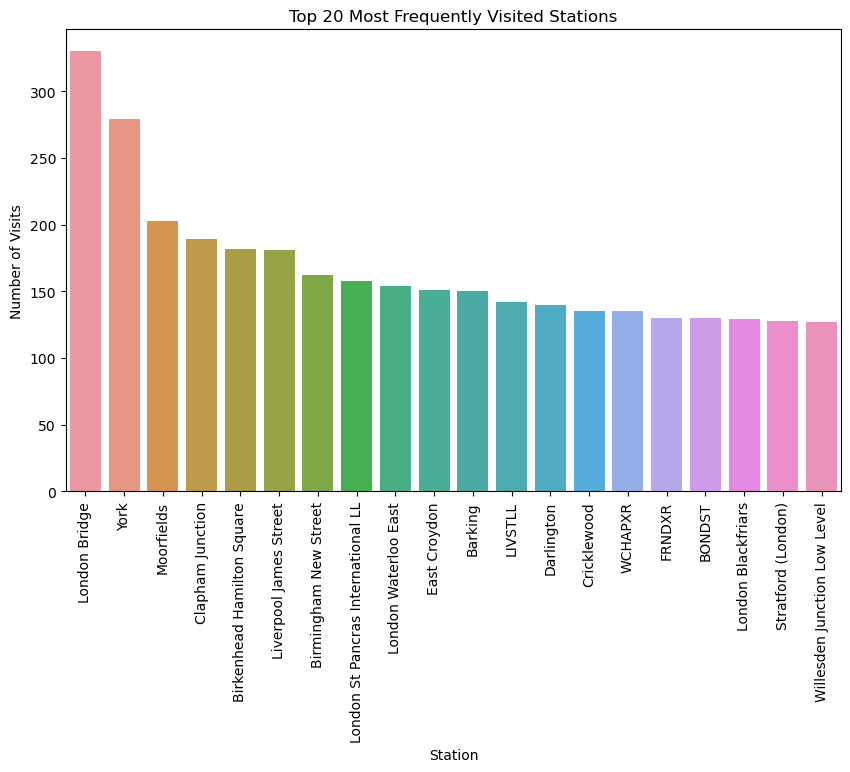

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
top_stations = df_merged['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title('Top 20 Most Frequently Visited Stations')
plt.xlabel('Station')
plt.ylabel('Number of Visits')
plt.xticks(rotation=90)
plt.show()